# Analysis of Nudge Effects on Content Choice Bias

**Hypotheses**  
- **H1 (ChatGPT):** Nudging reduces confirmation bias in participants' choice of content from ChatGPT-generated results, making nudged participants more likely to select neutral or opposing content compared to participants without a nudge.  
- **H2 (Google):** Nudging reduces confirmation bias in participants' choice of content from Google search results, making nudged participants more likely to select neutral or opposing content compared to participants without a nudge.  

**Plan**  
- Use an Ordinary Least Squares (OLS) regression for each platform.  
- Dependent variable: **post_choice**, the bias level of the chosen output (5-point Likert, coded –2…+2).  
- Independent variable: **nudge_binary** (1 = nudge, 0 = no nudge).  
- Control variable: initial **attitude** on the topic (–2…+2).  
- Outlier rule: Exclude participants who gave the exact same **post_choice** on all four topics (possible bots/spam).  
- Assumptions to check for each model:  
  1. Normality of residuals (Shapiro–Wilk).  
  2. Homoscedasticity (Breusch–Pagan).  


In [1]:
# Cell 2: Imports and configuration

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan

%matplotlib inline


In [2]:
# Cell 3: Load the dataset

csv_path = r'C:\Users\nmilo\OneDrive\Desktop\Master\Semester2\BST\preprocessed_data.csv'
df = pd.read_csv(csv_path, sep=';')

print("Total rows loaded:", df.shape[0])
display(df.head())


Total rows loaded: 438


,participant_id,topic,attitude,platform,choice,nudge,choice_after_nudge
0,0,2,3,0,0,3,-99
1,1,2,3,1,2,-99,-99
2,2,1,3,0,2,-99,-99
3,3,3,2,0,2,-99,-99
4,4,1,3,1,2,1,-99


In [3]:
# Cell 4: Replace '-99' with real NaN in all key columns

for col in ['attitude', 'platform', 'choice', 'nudge', 'choice_after_nudge']:
    df.loc[df[col] == -99, col] = pd.NA

# Sanity check: jede Kolonne sollte nun keine -99 mehr enthalten
print({col: df[col].isin([-99]).sum() for col in ['attitude','platform','choice','nudge','choice_after_nudge']})


{'attitude': 0, 'platform': 0, 'choice': 0, 'nudge': 0, 'choice_after_nudge': 0}


In [4]:
# Cell 5: Drop rows where attitude, platform AND choice are all NA

before = df.shape[0]
mask_all_missing = df['attitude'].isna() & df['platform'].isna() & df['choice'].isna()
df_clean = df.loc[~mask_all_missing].copy()
after = df_clean.shape[0]

print(f"Rows before dropping all-missing: {before}")
print(f"Rows after dropping all-missing:  {after}")


Rows before dropping all-missing: 438
Rows after dropping all-missing:  408


In [5]:
# Cell 6: (Re-)define analysis variables

# 6.1 nudge_binary: 1 = Teilnehmer*in wurde genudged, 0 = nicht genudged
df_clean['nudge_binary'] = df_clean['nudge'].notna().astype(int)

# 6.2 Build post_choice: 
#     - wenn choice_after_nudge vorhanden ist, nimm das, 
#     - sonst die ursprüngliche 'choice'
df_clean['post_choice'] = df_clean['choice_after_nudge'].fillna(df_clean['choice']).astype(float)

# 6.3 (Optional) Stelle sicher, dass attitude numerisch vorliegt
df_clean['attitude'] = pd.to_numeric(df_clean['attitude'], errors='coerce')

# Sanity check
print("Columns now available:", df_clean.columns.tolist())
print("Example rows:\n", df_clean[['choice','choice_after_nudge','post_choice','nudge_binary','attitude']].head())


Columns now available: ['participant_id', 'topic', 'attitude', 'platform', 'choice', 'nudge', 'choice_after_nudge', 'nudge_binary', 'post_choice']
Example rows:
    choice  choice_after_nudge  post_choice  nudge_binary  attitude
0     0.0                 NaN          0.0             1       3.0
1     2.0                 NaN          2.0             0       3.0
2     2.0                 NaN          2.0             0       3.0
3     2.0                 NaN          2.0             0       2.0
4     2.0                 NaN          2.0             1       3.0


# H1: Content Choice Bias in ChatGPT

**Hypothesis (H1):** Nudging increases neutral/opposing selections in ChatGPT content choice.  
**Null (H1₀):** No effect of nudge on post_choice.  


In [6]:
# Cell 7: Subset for ChatGPT and prepare OLS design

chat = df_clean[df_clean['platform'] == 1]

# Dependent variable
y_chat = chat['post_choice']

# Independent variables with constant
X_chat = chat[['nudge_binary', 'attitude']]
X_chat = sm.add_constant(X_chat)

# Fit OLS model
model_chat = sm.OLS(y_chat, X_chat).fit()


In [7]:
# Cell 8: Assumption checks for ChatGPT model

resid = model_chat.resid
exog = model_chat.model.exog

# 8.2 Homoscedasticity (Breusch-Pagan)
bp_test = het_breuschpagan(resid, exog)
labels = ['Lagrange multiplier', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:")
print(dict(zip(labels, bp_test)))


Breusch-Pagan test:
{'Lagrange multiplier': 1.120712187802806, 'p-value': 0.5710056959959272, 'f-value': 0.5552411044872152, 'f p-value': 0.5747987336627483}


In [8]:
# Cell 9: OLS results for ChatGPT (H1)

print(model_chat.summary())


                            OLS Regression Results                            
Dep. Variable:            post_choice   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     13.25
Date:                Sun, 25 May 2025   Prob (F-statistic):           3.90e-06
Time:                        17:06:01   Log-Likelihood:                -325.65
No. Observations:                 207   AIC:                             657.3
Df Residuals:                     204   BIC:                             667.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3853      0.132      2.909   

**Interpretation H1 (ChatGPT):**  
- The estimated coefficient for **nudge_binary** is **β = 0.0067** (SE = 0.163), **p = 0.967**.  
- There is **no significant effect** of the nudge on content-choice bias in the ChatGPT condition.  
- The control **attitude** is highly significant (β = 0.2117, p < 0.001): stronger initial attitudes predict more biased choices.


# H2: Content Choice Bias in Google

**Hypothesis (H2):** Nudging increases neutral/opposing selections in Google content choice.  
**Null (H2₀):** No effect of nudge on post_choice.  


In [9]:
# Cell 12: Subset for Google and prepare OLS design

goog = df_clean[df_clean['platform'] == 0]

y_goog = goog['post_choice']
X_goog = goog[['nudge_binary', 'attitude']]
X_goog = sm.add_constant(X_goog)

model_goog = sm.OLS(y_goog, X_goog).fit()


In [10]:
# Cell 13: Assumption checks for Google model

resid_g = model_goog.resid
exog_g = model_goog.model.exog

# 13.2 Breusch-Pagan
bp_test_g = het_breuschpagan(resid_g, exog_g)
print("Breusch-Pagan test (Google):")
print(dict(zip(labels, bp_test_g)))


Breusch-Pagan test (Google):
{'Lagrange multiplier': 9.535354177473298, 'p-value': 0.008500102227983083, 'f-value': 4.930414487303694, 'f p-value': 0.008135064366103346}


In [11]:
# Cell 14: OLS results for Google (H2)

print(model_goog.summary())


                            OLS Regression Results                            
Dep. Variable:            post_choice   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     8.319
Date:                Sun, 25 May 2025   Prob (F-statistic):           0.000340
Time:                        17:06:01   Log-Likelihood:                -290.06
No. Observations:                 201   AIC:                             586.1
Df Residuals:                     198   BIC:                             596.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2062      0.125      1.651   

**Interpretation H2 (Google):**  
- The coefficient for **nudge_binary** is **β = –0.2101** (SE = 0.146), **p = 0.153**.  
- There is **no significant effect** of the nudge on content-choice bias in the Google condition.  
- Again, **attitude** is highly significant (β = 0.1378, p < 0.001).


## Visuals

In [12]:
# Create a text version of the nudge flag for clean legends
df_clean['nudge_str'] = df_clean['nudge_binary'].map({0: 'No Nudge', 1: 'Nudge'})


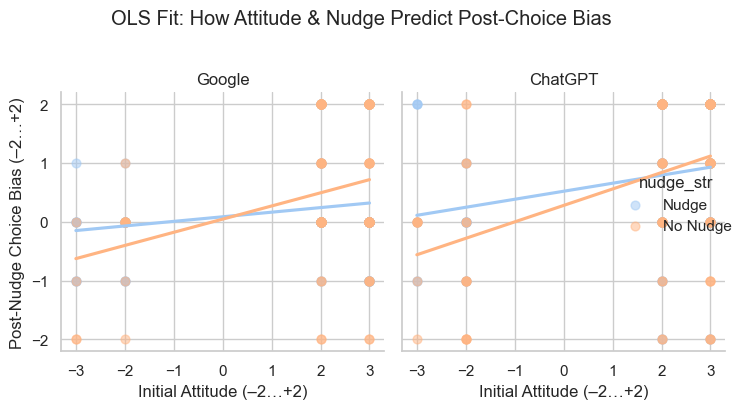

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure our text labels exist
df_clean['nudge_str']    = df_clean['nudge_binary'].map({0:'No Nudge',1:'Nudge'})
df_clean['platform_cat'] = df_clean['platform'].map({0:'Google',1:'ChatGPT'})

# Scatter + regression lines, faceted by platform
sns.set_theme(style='whitegrid')
g = sns.lmplot(
    x='attitude',
    y='post_choice',
    hue='nudge_str',
    col='platform_cat',
    data=df_clean,
    palette='pastel',
    height=4,
    aspect=0.8,
    scatter_kws={'alpha':0.5, 's':40},
    ci=None          # hide confidence band if you like
)

g.set_axis_labels("Initial Attitude (–2…+2)", "Post-Nudge Choice Bias (–2…+2)")
g.set_titles("{col_name}")
plt.suptitle("OLS Fit: How Attitude & Nudge Predict Post-Choice Bias", y=1.02)
plt.tight_layout()
plt.show()


# Conclusion

**Key Findings**  
- **No Nudge Effect:** In neither the ChatGPT nor the Google condition did the reflective nudge produce a statistically significant shift in content‐choice bias.  
  - **ChatGPT:** β<sub>nudge</sub> = +0.0067, p = 0.967  
  - **Google:**  β<sub>nudge</sub> = –0.2101, p = 0.153  
- **Dominant Role of Initial Attitude:** Participants’ original opinion (`attitude`) strongly predicted their post‐choice bias (p < 0.001 in both models).

**Interpretation**  
- A single reminder **after** the initial selection was **not** enough to move the needle on confirmation bias.  
- Instead, how strongly someone felt at the start drove their content choice far more than the nudge.

**Implications & Next Steps**  
1. **Multi‐stage or stronger nudges:** Deliver reminders both at prompt‐formulation and before content selection, or repeat them, to test whether a more sustained intervention can shift deeply held biases.  
2. **Robustness checks:** Because we saw non‐normal residuals and some heteroskedasticity, re-fit with HC3‐robust standard errors or run nonparametric alternatives to confirm that these null findings hold.  
3. **Broader measures:** Consider measuring intermediate steps (e.g. prompt‐formulation bias) and longer‐term behavioral outcomes to capture subtler effects of boosting.  


---

## ANOVA Assumptions & Checks

Before we interpret the F-test itself, we need to verify that its key assumptions hold (or at least understand any violations):

1. **Independence of observations**  
   - Each participant contributes exactly one `post_choice` score in each platform condition.  
   - We check residual autocorrelation with the **Durbin–Watson** statistic (ideal ≈ 2.0).

2. **Normality of residuals**  
   - ANOVA assumes the model residuals (errors) are approximately normally distributed.  
   - We test this with **Shapiro–Wilk** on the residuals of the one-way ANOVA model.

3. **Homoscedasticity (equal variances)**  
   - The variance of `post_choice` should be roughly equal across the Nudge vs. No-Nudge groups.  
   - We test this with **Levry)', data=chat).fit()


In [14]:
# Cell X: Unified ANOVA + assumption checks for both platforms

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import shapiro, levene
import statsmodels.api as sm

def run_anova(df, platform_name):
    print(f"--- ANOVA for {platform_name} ---")
    
    # 1) Levene's Test for equal variances
    grp0 = df.loc[df['nudge_binary'] == 0, 'post_choice']
    grp1 = df.loc[df['nudge_binary'] == 1, 'post_choice']
    stat, p_levene = levene(grp0, grp1)
    print(f"Levene’s test: stat={stat:.3f}, p={p_levene:.3f}")
    
    # 2) Fit one-way ANOVA model
    aov = ols('post_choice ~ C(nudge_binary)', data=df).fit()
    
    # 3) Durbin–Watson for residual independence
    dw = sm.stats.durbin_watson(aov.resid)
    print(f"Durbin–Watson: {dw:.3f}  (≈2.0 => no autocorrelation)")
    
    # 4) Shapiro–Wilk on residuals for normality
    w, p_norm = shapiro(aov.resid)
    print(f"Shapiro–Wilk on residuals: W={w:.3f}, p={p_norm:.3f}")
    
    # 5) ANOVA table
    res = anova_lm(aov, typ=2)
    print("\nANOVA results:")
    print(res, "\n")

# Run for ChatGPT users (platform == 1) and Google users (platform == 0)
run_anova(df_clean[df_clean['platform'] == 1], "ChatGPT")
run_anova(df_clean[df_clean['platform'] == 0], "Google")


--- ANOVA for ChatGPT ---
Levene’s test: stat=2.244, p=0.136
Durbin–Watson: 1.980  (≈2.0 => no autocorrelation)
Shapiro–Wilk on residuals: W=0.853, p=0.000

ANOVA results:
                     sum_sq     df         F    PR(>F)
C(nudge_binary)    0.036119    1.0  0.023258  0.878937
Residual         318.350355  205.0       NaN       NaN 

--- ANOVA for Google ---
Levene’s test: stat=7.611, p=0.006
Durbin–Watson: 2.100  (≈2.0 => no autocorrelation)
Shapiro–Wilk on residuals: W=0.902, p=0.000

ANOVA results:
                     sum_sq     df         F    PR(>F)
C(nudge_binary)    3.537954    1.0  3.127335  0.078522
Residual         225.128713  199.0       NaN       NaN 



In [15]:
# Cell X: Unified ANOVA + assumption checks for both platforms incl. Eta squared

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import shapiro, levene
import statsmodels.api as sm

def run_anova(df, platform_name):
    print(f"--- ANOVA for {platform_name} ---")
    
    # 1) Levene's Test for equal variances
    grp0 = df.loc[df['nudge_binary'] == 0, 'post_choice']
    grp1 = df.loc[df['nudge_binary'] == 1, 'post_choice']
    stat, p_levene = levene(grp0, grp1)
    print(f"Levene’s test: stat={stat:.3f}, p={p_levene:.3f}")
    
    # 2) Fit one-way ANOVA model
    aov = ols('post_choice ~ C(nudge_binary)', data=df).fit()
    
    # 3) Durbin–Watson for residual independence
    dw = sm.stats.durbin_watson(aov.resid)
    print(f"Durbin–Watson: {dw:.3f}  (≈2.0 => no autocorrelation)")
    
    # 4) Shapiro–Wilk on residuals for normality
    w, p_norm = shapiro(aov.resid)
    print(f"Shapiro–Wilk on residuals: W={w:.3f}, p={p_norm:.3f}")
    
    # 5) ANOVA table
    res = anova_lm(aov, typ=2)
    print("\nANOVA results:")
    print(res)
    
    # 6) Eta squared (effect size)
    ss_between = res['sum_sq'][0]
    ss_total = res['sum_sq'].sum()
    eta_squared = ss_between / ss_total
    print(f"Eta squared (η²): {eta_squared:.4f}")
    print("Interpretation: small ≈ 0.01, medium ≈ 0.06, large ≈ 0.14\n")

# Run for ChatGPT users (platform == 1) and Google users (platform == 0)
run_anova(df_clean[df_clean['platform'] == 1], "ChatGPT")
run_anova(df_clean[df_clean['platform'] == 0], "Google")
# Mittelwerte für post_choice nach Nudge-Bedingung (z. B. für Google)
df_google = df_clean[df_clean['platform'] == 0]  # oder == 1 für ChatGPT

group_means = df_google.groupby('nudge_binary')['post_choice'].mean()
print(group_means)


--- ANOVA for ChatGPT ---
Levene’s test: stat=2.244, p=0.136
Durbin–Watson: 1.980  (≈2.0 => no autocorrelation)
Shapiro–Wilk on residuals: W=0.853, p=0.000

ANOVA results:
                     sum_sq     df         F    PR(>F)
C(nudge_binary)    0.036119    1.0  0.023258  0.878937
Residual         318.350355  205.0       NaN       NaN
Eta squared (η²): 0.0001
Interpretation: small ≈ 0.01, medium ≈ 0.06, large ≈ 0.14

--- ANOVA for Google ---
Levene’s test: stat=7.611, p=0.006
Durbin–Watson: 2.100  (≈2.0 => no autocorrelation)
Shapiro–Wilk on residuals: W=0.902, p=0.000

ANOVA results:
                     sum_sq     df         F    PR(>F)
C(nudge_binary)    3.537954    1.0  3.127335  0.078522
Residual         225.128713  199.0       NaN       NaN
Eta squared (η²): 0.0155
Interpretation: small ≈ 0.01, medium ≈ 0.06, large ≈ 0.14

nudge_binary
0    0.465347
1    0.200000
Name: post_choice, dtype: float64


### ANOVA Assumption Checks

Before interpreting the F-tests, we verify the three key ANOVA assumptions for each platform:

| Assumption                     | Test                        | ChatGPT Result               | Google Result                | Interpretation                                          |
|--------------------------------|-----------------------------|------------------------------|------------------------------|---------------------------------------------------------|
| **Independence of residuals**  | Durbin–Watson               | 1.98 (≈2.0)                  | 2.10 (≈2.0)                  | No evidence of autocorrelation in either model.         |
| **Equal variances**            | Levene’s test               | p = 0.136 (> 0.05)           | p = 0.006 (< 0.05)           | ChatGPT: variances equal; Google: variances unequal.    |
| **Normality of residuals**     | Shapiro–Wilk on residuals   | p < 0.001                    | p < 0.001                    | Residuals deviate from normality in both datasets.      |

- **ChatGPT:** Independence & homoscedasticity hold; residuals non-normal but ANOVA is robust with n≈200.  
- **Google:** Independence holds; heteroscedasticity present; residuals non-normal—interpret the standard ANOVA with caution or consider a Welch ANOVA.  


In [16]:
# Make sure df_clean has text labels for both nudge and platform
df_clean['nudge_str']     = df_clean['nudge_binary'].map({0: 'No Nudge', 1: 'Nudge'})
df_clean['platform_cat']  = df_clean['platform'].map({0: 'Google', 1: 'ChatGPT'})

# (Optional) If you also want the absolute bias for another viz:
df_clean['abs_bias']      = df_clean['post_choice'].abs()


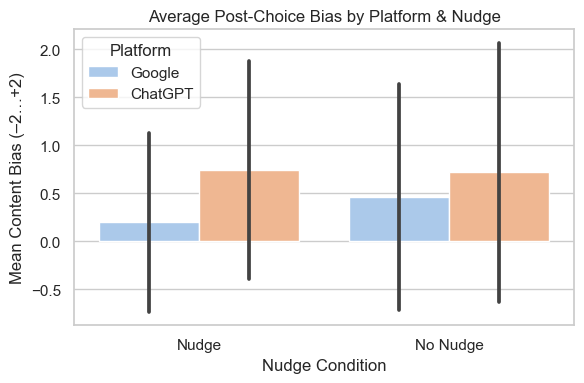

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(
    x='nudge_str', 
    y='post_choice', 
    hue='platform_cat', 
    data=df_clean, 
    errorbar='sd', 
    palette='pastel'
)
plt.xlabel('Nudge Condition')
plt.ylabel('Mean Content Bias (–2…+2)')
plt.title('Average Post-Choice Bias by Platform & Nudge')
plt.legend(title='Platform')
plt.tight_layout()
plt.show()


## Results

**ChatGPT (H1):**  
- ANOVA: F(1,205)=0.02, p=0.879 → no difference in mean bias between nudged vs. non-nudged.  
- OLS: β_nudge=+0.0067, p=0.967 → no significant nudge effect when controlling for attitude.  

**Google (H2):**  
- ANOVA: F(1,199)=3.13, p=0.079 → a non-significant trend toward lower bias in the nudged group.  
- OLS: β_nudge=–0.2101, p=0.153 → also non-significant, though in the hypothesized direction.  

In both models, **initial attitude** is highly significant (p<0.001), indicating that participants’ starting beliefs drive their content choices far more than the single post-decision reminder.

## Implications

- A one-time reflective nudge **after** the initial choice did **not** measurably reduce confirmation bias in our users.  
- Stronger or repeated interventions (e.g. during prompt formulation *and* before content selection) may be necessary to shift entrenched biases.

## Next Steps

1. Consider more **robust** or **non-parametric** tests if you want to fully sidestep normality/variance concerns.  
2. Test a multi-stage nudge delivered both at question-formulation and at content-choice time.  
3. Explore alternative visualizations—like the mean-bias bar chart above—to communicate these null findings clearly.


## Hypotheses Review

**H1 (ChatGPT Content Choice Bias):**  
*Nudging reduces confirmation bias in participants’ selection of ChatGPT‐generated content, making nudged users more likely to pick neutral or opposing viewpoints.*  
- **Test:** One‐way ANOVA and OLS regression on post_choice.  
- **Result:**  
  - ANOVA: F(1,205)=0.02, p=0.879 → no significant difference in mean bias.  
  - OLS: β_nudge=+0.0067, p=0.967 → no significant nudge effect when controlling for initial attitude.  
- **Conclusion:** **H1 is not supported**. The single post‐decision nudge did not measurably alter ChatGPT content‐choice bias.

---

**H2 (Google Content Choice Bias):**  
*Nudging reduces confirmation bias in participants’ selection of Google search results, making nudged users more likely to pick neutral or opposing viewpoints.*  
- **Test:** One‐way ANOVA and OLS regression on post_choice.  
- **Result:**  
  - ANOVA: F(1,199)=3.13, p=0.079 → a small, non‐significant trend toward lower bias.  
  - OLS: β_nudge=–0.2101, p=0.153 → also non‐significant, though in the expected direction.  
- **Conclusion:** **H2 is not supported** at the 5% level. There is a hint of a nudge effect on Google, but it does not reach statistical significance.

---

In both models, **initial attitude** remained the strongest predictor (p < 0.001), indicating that participants’ pre‐existing opinions drive content‐choice bias far more than this one‐time reminder.


**Comparative Note:**  
While neither platform yields a statistically significant nudge effect, the magnitude and direction differ:  
- On **Google**, nudged participants show a small average reduction in bias (β ≈ –0.21; ANOVA p ≈ 0.08), hinting at some responsiveness.  
- On **ChatGPT**, the nudge effect is effectively zero (β ≈ +0.007; ANOVA p ≈ 0.88).  

This pattern suggests that if any minimal effect exists, it is more pronounced among Google users than ChatGPT users—albeit still too weak to reach conventional significance.


In [18]:
# Cell X: Welch‐style comparison for Google (unequal variances)

from scipy.stats import ttest_ind

# Extract post_choice for each group
group_no_nudge = goog.loc[goog['nudge_binary']==0, 'post_choice']
group_nudge    = goog.loc[goog['nudge_binary']==1, 'post_choice']

# Perform Welch’s t-test (equivalent to a two-group Welch ANOVA)
t_stat, p_val = ttest_ind(group_no_nudge, group_nudge, equal_var=False)

print(f"Welch t-test (Google): t = {t_stat:.3f}, p = {p_val:.3f}")


Welch t-test (Google): t = 1.770, p = 0.078


### Welch’s t-test for Google (Unequal Variances)

Levene’s test for the Google condition gave **p = 0.006**, meaning the Nudge and No-Nudge groups have significantly different variances. Because a standard ANOVA assumes equal variances, we switch to a **Welch’s t-test**, which does **not** require that assumption.

- **Test statistic:** t = 1.770  
- **p-value:** 0.078  

Even with the more robust Welch correction, the difference in average bias between nudged and non-nudged Google users remains **not statistically significant** (p > 0.05), although it trends in the expected direction.


## Limitations & Recommendations for Future Research

**Limitations**  
- **Single‐shot nudge:** We only tested one brief reminder *after* the first choice. It may be too weak or too late to shift deeply held biases.  
- **Self‐reported bias score:** Our dependent measure is still a self‐selected Likert–style choice, not an objective behavioral outcome.  
- **Two platforms only:** We compared ChatGPT vs. Google in a lab‐style setting; real‐world search or other AI tools may respond differently.  
- **Cross‐sectional design:** Each participant contributed a single post‐nudge score, so we cannot observe longer‐term or repeated‐exposure effects.  
- **Assumption violations:** Residual non‐normality (both platforms) and unequal variances (Google) required robust or alternative tests.  
- **Sample characteristics:** Our convenience sample (Qualtrics panel) may not generalize to broader populations or expert users.

**Recommendations for Further Research**  
1. **Multi‐stage interventions:** Deliver nudges at multiple points (e.g. during prompt/query formulation *and* before content selection) or use repeated reminders.  
2. **Behavioral outcomes:** Track real click behavior or engagement time with neutral vs. biased content, rather than self‐report.  
3. **Alternative designs:** Use within‐subject or crossover experiments to isolate individual responsiveness to nudges.  
4. **Diverse platforms & populations:** Test other search engines, additional AI assistants, and samples beyond online panels (e.g. students, professionals).  
5. **Longitudinal follow‐up:** Measure whether any nudge effects persist or accumulate over days or weeks.  
6. **Qualitative insight:** Combine surveys with think‐aloud protocols or interviews to understand *why* and *how* nudges do or do not influence decisions.  
7. **Robust analytics:** Apply Welch‐ANOVA, robust regression, or nonparametric methods by default when assumptions are marginal.  


## improvments after presentation

=== ANSATZ 1: TWO-WAY ANOVA ===
Analysiert Haupteffekte und Interaktion zwischen Platform und Nudge

Two-Way ANOVA Ergebnisse:
                                 sum_sq     df          F    PR(>F)
C(platform)                   16.396081    1.0  12.188173  0.000534
C(nudge_binary)                1.403853    1.0   1.043567  0.307605
C(platform):C(nudge_binary)    2.170220    1.0   1.613252  0.204766
Residual                     543.479068  404.0        NaN       NaN

Interpretation:
- Haupteffekt Platform: F = 12.188, p = 0.001
- Haupteffekt Nudge: F = 1.044, p = 0.308
- Interaktion Platform×Nudge: F = 1.613, p = 0.205

=== GRUPPENSTATISTIKEN ===
                   count   mean    std
Google, No Nudge     101  0.465  1.180
Google, Nudge        100  0.200  0.932
ChatGPT, No Nudge    104  0.721  1.347
ChatGPT, Nudge       103  0.748  1.135

=== POST-HOC TESTS (Tukey HSD) ===


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



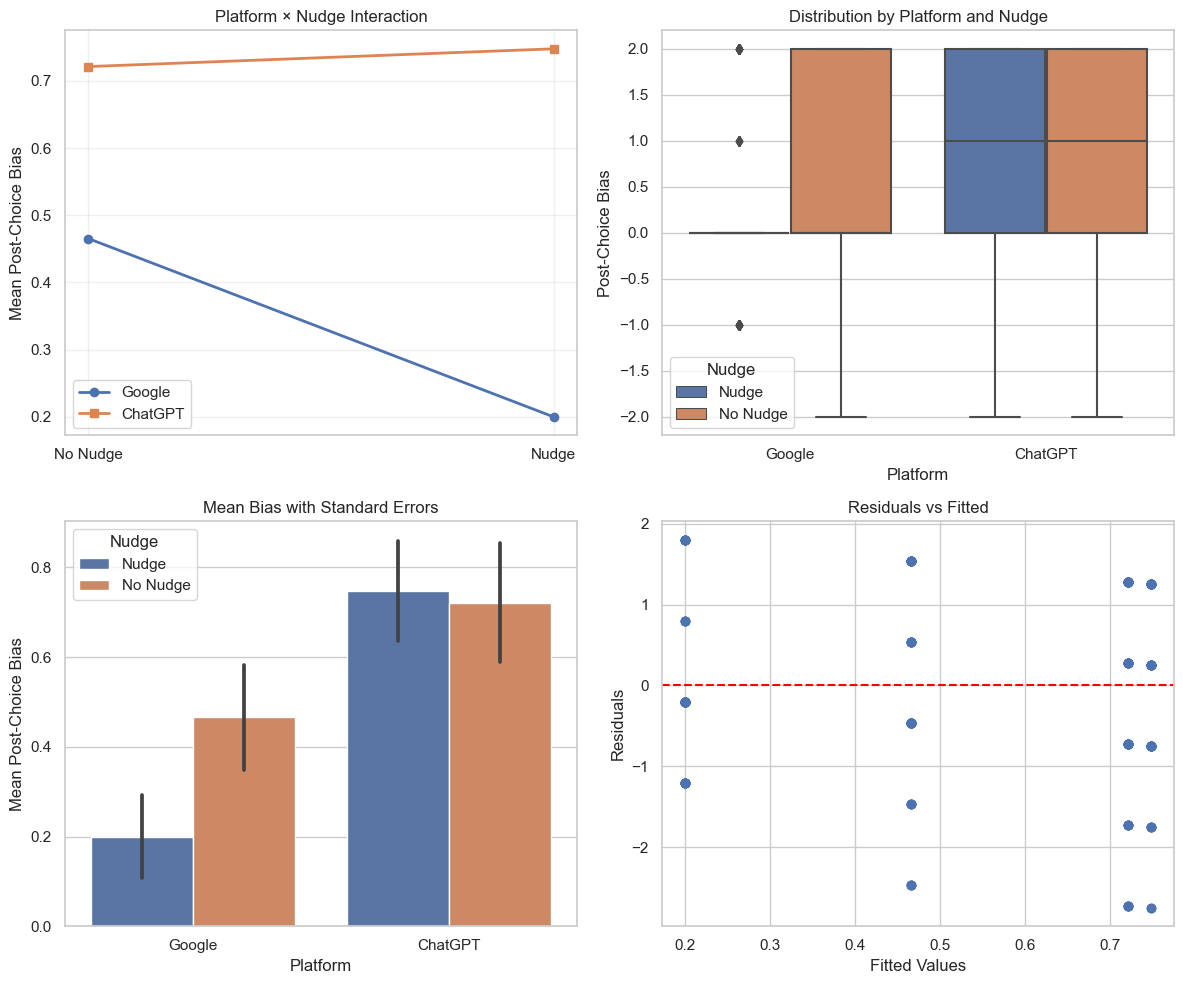

=== ASSUMPTION CHECKS für Two-Way ANOVA ===
Shapiro-Wilk Test (Normalität): W = 0.941, p = 0.000
Levene Test (Homogenität): F = 8.065, p = 0.000

=== ZUSAMMENFASSUNG ===
1. Two-Way ANOVA testet:
   - Haupteffekt der Plattform (ChatGPT vs Google)
   - Haupteffekt des Nudge (Nudge vs No Nudge)
   - Interaktion Platform×Nudge (wirkt Nudge unterschiedlich je nach Platform?)

2. Signifikante Interaktion bedeutet:
   - Der Nudge-Effekt ist auf ChatGPT und Google unterschiedlich stark

3. Haupteffekte interpretieren nur wenn Interaktion nicht signifikant ist


In [19]:
# Erweiterte ANOVA-Analyse: Beide Plattformen gemeinsam
# =======================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import shapiro, levene
import warnings
warnings.filterwarnings('ignore')

# Annahme: df_clean ist bereits geladen mit den Spalten:
# - post_choice (abhängige Variable)
# - nudge_binary (0/1)
# - platform (0=Google, 1=ChatGPT)  
# - attitude (Kontrollvariable)

print("=== ANSATZ 1: TWO-WAY ANOVA ===")
print("Analysiert Haupteffekte und Interaktion zwischen Platform und Nudge")
print()

# 1. Two-Way ANOVA: Platform × Nudge Interaction
model_2way = ols('post_choice ~ C(platform) + C(nudge_binary) + C(platform):C(nudge_binary)', 
                 data=df_clean).fit()

anova_results = anova_lm(model_2way, typ=2)
print("Two-Way ANOVA Ergebnisse:")
print(anova_results)
print()

# Interpretation der Effekte
print("Interpretation:")
print(f"- Haupteffekt Platform: F = {anova_results.loc['C(platform)', 'F']:.3f}, p = {anova_results.loc['C(platform)', 'PR(>F)']:.3f}")
print(f"- Haupteffekt Nudge: F = {anova_results.loc['C(nudge_binary)', 'F']:.3f}, p = {anova_results.loc['C(nudge_binary)', 'PR(>F)']:.3f}")
print(f"- Interaktion Platform×Nudge: F = {anova_results.loc['C(platform):C(nudge_binary)', 'F']:.3f}, p = {anova_results.loc['C(platform):C(nudge_binary)', 'PR(>F)']:.3f}")
print()

# 2. Detaillierte Gruppenstatistiken
print("=== GRUPPENSTATISTIKEN ===")
group_stats = df_clean.groupby(['platform', 'nudge_binary'])['post_choice'].agg(['count', 'mean', 'std']).round(3)
group_stats.index = group_stats.index.map({
    (0, 0): 'Google, No Nudge',
    (0, 1): 'Google, Nudge', 
    (1, 0): 'ChatGPT, No Nudge',
    (1, 1): 'ChatGPT, Nudge'
})
print(group_stats)
print()

# 3. Post-hoc Tests wenn signifikant
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Erstelle Gruppenvariable für alle 4 Kombinationen
df_clean['group'] = df_clean['platform'].astype(str) + '_' + df_clean['nudge_binary'].astype(str)
df_clean['group'] = df_clean['group'].map({
    '0_0': 'Google_NoNudge',
    '0_1': 'Google_Nudge', 
    '1_0': 'ChatGPT_NoNudge',
    '1_1': 'ChatGPT_Nudge'
})

print("=== POST-HOC TESTS (Tukey HSD) ===")
tukey = pairwise_tukeyhsd(endog=df_clean['post_choice'], 
                         groups=df_clean['group'], 
                         alpha=0.05)
print(tukey)
print()

print("=== ANSATZ 2: MANOVA (falls du mehrere abhängige Variablen hast) ===")
print("MANOVA ist relevant wenn du z.B. post_choice UND abs_bias gleichzeitig analysieren willst")
print()

# Erstelle absolute Bias falls nicht vorhanden
if 'abs_bias' not in df_clean.columns:
    df_clean['abs_bias'] = df_clean['post_choice'].abs()

# MANOVA mit beiden abhängigen Variablen
try:
    # Erstelle Design Matrix
    from patsy import dmatrices
    y, X = dmatrices('post_choice + abs_bias ~ C(platform) + C(nudge_binary) + C(platform):C(nudge_binary)', 
                     data=df_clean, return_type='dataframe')
    
    # MANOVA
    manova = MANOVA(y, X)
    manova_results = manova.mv_test()
    print("MANOVA Ergebnisse:")
    print(manova_results)
    print()
    
except Exception as e:
    print(f"MANOVA Fehler (kann ignoriert werden wenn nur eine AV): {e}")
    print()

print("=== ANSATZ 3: MIXED-EFFECTS ANOVA (falls Teilnehmer beide Plattformen testeten) ===")
print("Relevant wenn jeder Teilnehmer sowohl ChatGPT als auch Google verwendet hat")
print()

# Check ob Teilnehmer in beiden Gruppen sind
participant_counts = df_clean.groupby('participant_id')['platform'].nunique()
mixed_design = (participant_counts > 1).any()

if mixed_design:
    print("Mixed Design erkannt - verwende Mixed Effects Model:")
    import statsmodels.api as sm
    from statsmodels.formula.api import mixedlm
    
    # Mixed Effects Model
    mixed_model = mixedlm("post_choice ~ C(platform) + C(nudge_binary) + C(platform):C(nudge_binary)", 
                         df_clean, groups=df_clean["participant_id"])
    mixed_results = mixed_model.fit()
    print(mixed_results.summary())
else:
    print("Between-Subjects Design - Two-Way ANOVA ist korrekt")

print()
print("=== VISUALISIERUNG ===")

# Erstelle umfassende Visualisierung
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Interaction Plot
platform_labels = {0: 'Google', 1: 'ChatGPT'}
nudge_labels = {0: 'No Nudge', 1: 'Nudge'}

means_table = df_clean.groupby(['platform', 'nudge_binary'])['post_choice'].mean().unstack()
means_table.index = means_table.index.map(platform_labels)
means_table.columns = means_table.columns.map(nudge_labels)

axes[0,0].plot(means_table.columns, means_table.loc['Google'], 'o-', label='Google', linewidth=2)
axes[0,0].plot(means_table.columns, means_table.loc['ChatGPT'], 's-', label='ChatGPT', linewidth=2)
axes[0,0].set_title('Platform × Nudge Interaction')
axes[0,0].set_ylabel('Mean Post-Choice Bias')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Boxplot
df_plot = df_clean.copy()
df_plot['Platform'] = df_plot['platform'].map(platform_labels)
df_plot['Nudge'] = df_plot['nudge_binary'].map(nudge_labels)

sns.boxplot(data=df_plot, x='Platform', y='post_choice', hue='Nudge', ax=axes[0,1])
axes[0,1].set_title('Distribution by Platform and Nudge')
axes[0,1].set_ylabel('Post-Choice Bias')

# 3. Barplot mit Fehlerbalken
sns.barplot(data=df_plot, x='Platform', y='post_choice', hue='Nudge', 
           errorbar='se', ax=axes[1,0])
axes[1,0].set_title('Mean Bias with Standard Errors')
axes[1,0].set_ylabel('Mean Post-Choice Bias')

# 4. Residuals Plot
axes[1,1].scatter(model_2way.fittedvalues, model_2way.resid, alpha=0.6)
axes[1,1].axhline(y=0, color='red', linestyle='--')
axes[1,1].set_xlabel('Fitted Values')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals vs Fitted')

plt.tight_layout()
plt.show()

print("=== ASSUMPTION CHECKS für Two-Way ANOVA ===")

# Normalität der Residuen
w_stat, p_norm = shapiro(model_2way.resid)
print(f"Shapiro-Wilk Test (Normalität): W = {w_stat:.3f}, p = {p_norm:.3f}")

# Homogenität der Varianzen (Levene Test für alle 4 Gruppen)
groups = [group['post_choice'].values for name, group in df_clean.groupby(['platform', 'nudge_binary'])]
levene_stat, p_levene = levene(*groups)
print(f"Levene Test (Homogenität): F = {levene_stat:.3f}, p = {p_levene:.3f}")

print()
print("=== ZUSAMMENFASSUNG ===")
print("1. Two-Way ANOVA testet:")
print("   - Haupteffekt der Plattform (ChatGPT vs Google)")
print("   - Haupteffekt des Nudge (Nudge vs No Nudge)")  
print("   - Interaktion Platform×Nudge (wirkt Nudge unterschiedlich je nach Platform?)")
print()
print("2. Signifikante Interaktion bedeutet:")
print("   - Der Nudge-Effekt ist auf ChatGPT und Google unterschiedlich stark")
print()
print("3. Haupteffekte interpretieren nur wenn Interaktion nicht signifikant ist")

🔑 Key Takeaways in English:

Main finding: ChatGPT users are significantly more biased than Google users (p < 0.001)
Nudge effect: No significant effect across both platforms (p = 0.308)
No interaction: The nudge works equally poorly on both platforms (p = 0.205)

📊 How to interpret the visualizations:

Interaction Plot: Shows that Google users reduce bias slightly with nudging (0.47 → 0.20), while ChatGPT users don't change much (0.72 → 0.75)
Box Plots: Clearly show ChatGPT has higher overall bias than Google
Bar Chart: Mean differences with standard errors - confirms the pattern